<a href="https://colab.research.google.com/github/Farii01/Internship_PINN_work/blob/main/June_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://gricad-gitlab.univ-grenoble-alpes.fr/claveaur/pygeotools.git

  Cloning https://gricad-gitlab.univ-grenoble-alpes.fr/claveaur/pygeotools.git to /tmp/pip-req-build-k8alo8c8
  Running command git clone --filter=blob:none --quiet https://gricad-gitlab.univ-grenoble-alpes.fr/claveaur/pygeotools.git /tmp/pip-req-build-k8alo8c8
  Resolved https://gricad-gitlab.univ-grenoble-alpes.fr/claveaur/pygeotools.git to commit 87d5eab82dbae0c55a8d93113cd4ac6db38a0bf0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import pygeotools
import torch
import torch.nn as nn
import numpy

In [3]:
model_path = "/content/COVOBS-x2_400reals.hdf5"

pygeo = pygeotools.pygeotools()
model_name=  "COVOBS-x2_400reals.hdf5"
pygeo.loadModel(
    modelName="COVOBS",
    modelType="covobs_hdf5",
    modelPath="COVOBS-x2_400reals.hdf5"
)


pygeo.isLoaded("COVOBS")  # Should return True

pygeotools was initialized with `verbose=True`.


True

### Retrieving the data

In [4]:
# Setting the grid
pygeo.setGrid("1deg")

# Creating the context
context = {
    "lmax": 13,
    "r": pygeo.constants["rCore"]
}

In [5]:
# Computing the MF and SV
MF = pygeo.addMeasure("COVOBS", "MF", context)
SV = pygeo.addMeasure("COVOBS", "SV", context)

13


The mean of Br across all realizations = Br_obs

The standard deviation across realizations = σᵢ

In [6]:
# Retrieving the grid
_, (thetas, phis) = pygeo.getCurrentGrid()

## Generating the patches for input in PINN

we cut the Earth into small square patches, train a separate neural network on each patch, then stitch the results together.


In [7]:
def generate_patches(theta_size=20, phi_size=20, overlap=5):# 20 rows longitude, 20 cols latitude
    patches = []
# without overlap
    dtheta = theta_size - overlap
    dphi = phi_size - overlap

#going from pole to pole (0 to 180 in colatitude) by stepping in 15° chunks (because dtheta = 15)
    for i1 in range(0, 180 - theta_size + 1, dtheta):
        i2 = i1 + theta_size
        for j1 in range(0, 360 - phi_size + 1, dphi):
            j2 = j1 + phi_size

            patches.append((i1, i2, j1, j2))

    return patches
'''
This loop creates a full list of (i1, i2, j1, j2) — patches of size 20°×20°, sliding across the whole globe, overlapping 5°.

Each patch will be used to train a small PINN, then all will be stitched together into one global map.
'''
# How to use?
patches = generate_patches(theta_size=20, phi_size=20, overlap=5)

for i1, i2, j1, j2 in patches:
    ... # For each patch, we have to solve the inverse problem

In [8]:
Br = pygeo.selectFromMeasure("COVOBS", MF, options={"component": "r", "time": 2020})
dBrdt = pygeo.selectFromMeasure("COVOBS", SV, options={"component": "r", "time": 2020})

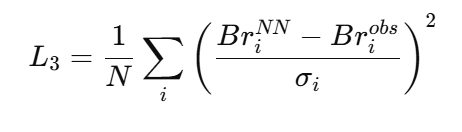

In [17]:
# Select Br for all realizations (shape: [Ntheta, Nphi, Nreals, Ntimes])
Br_full = pygeo.selectFromMeasure(
    modelName="COVOBS",
    measure=MF,
    options={
        "components": (0,),   # radial component Br
        "reals": (0, 400)     # all 400 realizations
    }
)

# Remove singleton time dimension (final shape: [Ntheta, Nphi, Nreals])
Br_all = Br_full[..., 0]

# Slice the patch from the 3D field (ni × nj × 400)
Br_patch_all = Br_all[i1:i2, j1:j2, :]

# Compute patchwise mean and std across realizations (along last axis)
Br_obs_patch = torch.mean(torch.tensor(Br_patch_all), dim=-1, keepdim=True)     # [ni, nj, 1]
sigma_i_patch = torch.std(torch.tensor(Br_patch_all), dim=-1, keepdim=True)     # [ni, nj, 1]

# Flatten to match NN output shape [ni*nj, 1]
Br_obs = Br_obs_patch.reshape(-1, 1)
sigma_i = sigma_i_patch.reshape(-1, 1)


### Creating the NN

In [10]:
node_inputs = 2
node_outputs = 2
node_layer = 64
hidden_layers = 3

In [11]:
#  Defining the NN
# For now, it has one hidden layer with 32 nodes
# The activation functions are TANH
class CoreFlowPINN(nn.Module):
    def __init__(self):
        super(CoreFlowPINN, self).__init__()

        layers = []

        layers.append(nn.Linear(node_inputs, node_layer))
        layers.append(nn.Tanh())

        for _ in range(hidden_layers):
            layers.append(nn.Linear(node_layer, node_layer))
            layers.append(nn.Tanh())

        layers.append(nn.Linear(node_layer, node_outputs))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [12]:
print(f"Number of patches: {len(patches)}")


Number of patches: 253


### Adding the physics

In [18]:
"""
We want to solve the radial induction equation at the CMB
    dBr / dt + ∇h • (Uh Br) = 0

with some quasi-geostrophic condition (meaning the flow will partly align along the axis of rotation, making columns-like flow)
    ∇h • (Uh cos(θ)) = 0

As the flow is incompressible, it is subject to ∇ • U = 0. As a result, it admits a unique toroidal-poloidal decomposition:
    Uh = ∇ x (r T) + ∇ (r S)

Thus, instead of directly predicting uθ and uφ, it appears clever to predict T and S as it already enforces the incompressibility condition.

In spherical coordinates, one has
    uθ = -(dT/dφ) / sin(θ) + dS/dθ
    uφ = dT/dθ + (dS/dφ) / sin(θ)
"""

r = torch.tensor(pygeo.constants["rCore"]) # placing ourselves at the CMB

def compute_loss(model, inputs, thetas_nn, phis_nn, Br_nn, Br_obs, sigma_i, dBrdt_nn, dBrdth_nn, dBrdph_nn):


    # Retrieving the predicted flow
    u_pred = model(inputs)

    # Retrieving the toroidal and poloidal components

    T = u_pred[:, 0:1]
    S = u_pred[:, 1:2]

    # First derivatives of T and S
    dT_dth = torch.autograd.grad(T, thetas_nn, grad_outputs=torch.ones_like(T), create_graph=True, retain_graph=True)[0]
    dT_dph = torch.autograd.grad(T, phis_nn, grad_outputs=torch.ones_like(T), create_graph=True, retain_graph=True)[0]
    dS_dth = torch.autograd.grad(S, thetas_nn, grad_outputs=torch.ones_like(S), create_graph=True, retain_graph=True)[0]
    dS_dph = torch.autograd.grad(S, phis_nn, grad_outputs=torch.ones_like(S), create_graph=True, retain_graph=True)[0]

    """
    Computing L1
    """
    # Computing the L1² loss function
    # L1² = || dBr / dt + ∇h • (Uh Br) ||²
    # ∇h • (Uh Br) = (∇h • Uh) Br + Uh • (∇h Br)

    sin_th = torch.sin(thetas_nn)
    cos_th = torch.cos(thetas_nn)
    tan_th = torch.tan(thetas_nn)

    # We are defining u_th and u_ph with T and S
    u_th = -dT_dph / sin_th + dS_dth
    u_ph = dT_dth + dS_dph / sin_th

    # Computing ∇h • Uh
    u_th_sin_th = u_th * sin_th
    d_u_th_sin_th_dth = torch.autograd.grad(u_th_sin_th, thetas_nn, grad_outputs=torch.ones_like(u_th_sin_th), create_graph=True, retain_graph=True)[0]

    d_u_ph_dph = torch.autograd.grad(u_ph, phis_nn, grad_outputs=torch.ones_like(u_ph), create_graph=True, retain_graph=True)[0]

    divH_uH = (1 / (r * sin_th)) * (d_u_th_sin_th_dth + d_u_ph_dph)
    # divH_uH = u_th * tan_th / r

    # Computing ∇h Br
    # The derivatives are provided as they are not the NN variables but inputs
    gradH_Br_th = (1 / r) * dBrdth_nn
    gradH_Br_ph = (1 / (r * sin_th)) * dBrdph_nn

    # Wrapping the induction equation
    L1 = dBrdt_nn + Br_nn * divH_uH + u_th * gradH_Br_th + u_ph * gradH_Br_ph

    """
    Computing L2
    """
    L2 = divH_uH - u_th * tan_th / r

    """
    Computing L3
    """
    # L3 = (1/N) * Σ_i [ (Br_nn - Br_obs) / sigma_i ]²

    Br_residual = Br_nn - Br_obs
    L3 = torch.mean((Br_residual / sigma_i) ** 2)



    return L1, L2, L3, u_th, u_ph

In [19]:
Br_obs.shape


torch.Size([400, 1])

In [20]:
# I moved everything to the training loop so that for each patch in every iteration, the model receives the correct,
# patch-specific input like thetas_nn, phis_nn, Br_nn, dBrdt_nn, dBrdth_nn, dBrdph_nn



# Training over all patches
num_realizations = 5 # 5 time on each patch
epochs = 100
λ = 1000

patch_centers=[]


print(f"Number of times each patch will run: {num_realizations}")
print(f"Number of epochs: {epochs}")


'''
# for all patches
for i1, i2, j1, j2 in patches:
    if i1 < 10 or i2 > 170 or (i1 <= 90 <= i2):
        continue  # skip poles and equator

'''

# for less time consumption, I am using 50 patches
test_patches = patches[ :30] # you can slice it if u want less, that is why i created a seperate variable

print(f"Number of patches: {len(patches)} but we will consider : {len(test_patches)}")

for patch_idx, (i1, i2, j1, j2) in enumerate(test_patches, start=1):
    # Skip poles and equator patches if needed
    if i1 < 10 or i2 > 170 or (i1 <= 90 <= i2):
      continue


    print(f"Processing from patch {patch_idx} Since the ones before were either equator or pole") # To know when it is starting and what is getting out of calculation

#slice all Br and inputs
    Br_patch = Br[i1:i2, j1:j2, ...]
    dBrdt_patch = dBrdt[i1:i2, j1:j2, ...]

    #differential or br and sv w.r.t. phi and theta
    dBrdth = numpy.gradient(Br, thetas, axis=0)[i1:i2, j1:j2, ...]
    dBrdph = numpy.gradient(Br, phis, axis=1)[i1:i2, j1:j2, ...]

    thetas_bis = thetas[i1:i2]
    phis_bis = phis[j1:j2]

    thetas_grid, phis_grid = numpy.meshgrid(thetas_bis, phis_bis, indexing="ij")
    thetas_flat = thetas_grid.flatten()
    phis_flat = phis_grid.flatten()

    thetas_nn = torch.tensor(thetas_flat[:, None], dtype=torch.float32, requires_grad=True)
    phis_nn = torch.tensor(phis_flat[:, None], dtype=torch.float32, requires_grad=True)
    Br_nn = torch.tensor(Br_patch.flatten()[:, None], dtype=torch.float32)
    dBrdt_nn = torch.tensor(dBrdt_patch.flatten()[:, None], dtype=torch.float32)
    dBrdth_nn = torch.tensor(dBrdth.flatten()[:, None], dtype=torch.float32)
    dBrdph_nn = torch.tensor(dBrdph.flatten()[:, None], dtype=torch.float32)

    inputs = torch.cat([thetas_nn, phis_nn], dim=1)

    loss_history = []


    for run in range(num_realizations):

        print(f"\n === Training run {run + 1}/{num_realizations} === Patches: {patch_idx}")
        model = CoreFlowPINN()
        optimizer = torch.optim.Adam(model.parameters(), 0.001)

        for epoch in range(epochs):
            optimizer.zero_grad()
            L1, L2,L3, _,_ = compute_loss(model, inputs, thetas_nn, phis_nn, Br_nn, Br_obs, sigma_i, dBrdt_nn, dBrdth_nn, dBrdph_nn)
            L1_loss = (L1**2).mean()
            L2_loss = (L2**2).mean()
            L3_loss = (L3**2).mean()
            Loss = L1_loss + λ * L2_loss + L3_loss
            Loss.backward()

            optimizer.step()

            if epoch % 5 == 0:
                print(f"Epoch {epoch:4d} | L1 Loss: {L1_loss.item():12.6e} | L2 Loss: {L2_loss.item():12.6e} | Total Loss: {Loss.item():12.6e}", flush=True)

            # for graphs
            loss_history.append(Loss)

    #mean_loss_map = numpy.mean(loss_history, axis=0)
    #loss_grid = mean_loss_map.reshape(len(thetas_bis), len(phis_bis))
    patch_centers.append(((i1 + i2) // 2, (j1 + j2) // 2)) # for SV later


print(" Done computing for all patches.")


Number of times each patch will run: 5
Number of epochs: 100
Number of patches: 253 but we will consider : 30
Processing from patch 24 Since the ones before were either equator or pole

 === Training run 1/5 === Patches: 24
Epoch    0 | L1 Loss: 1.373680e+06 | L2 Loss: 7.846031e-10 | Total Loss: 2.049208e+18
Epoch    5 | L1 Loss: 9.684502e+05 | L2 Loss: 1.139481e-08 | Total Loss: 2.049208e+18


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [400, 1], strides() = [1, 0]
param.sizes() = [400, 1], strides() = [1, 0] (Triggered internally at /pytorch/torch/csrc/autograd/functions/accumulate_grad.h:218.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch   10 | L1 Loss: 9.407132e+05 | L2 Loss: 1.341497e-08 | Total Loss: 2.049208e+18
Epoch   15 | L1 Loss: 8.792766e+05 | L2 Loss: 1.060900e-08 | Total Loss: 2.049208e+18
Epoch   20 | L1 Loss: 8.480868e+05 | L2 Loss: 5.548029e-08 | Total Loss: 2.049208e+18
Epoch   25 | L1 Loss: 8.132165e+05 | L2 Loss: 2.994423e-07 | Total Loss: 2.049208e+18
Epoch   30 | L1 Loss: 7.621212e+05 | L2 Loss: 8.703038e-07 | Total Loss: 2.049208e+18
Epoch   35 | L1 Loss: 7.073329e+05 | L2 Loss: 2.250013e-06 | Total Loss: 2.049208e+18
Epoch   40 | L1 Loss: 6.372609e+05 | L2 Loss: 5.562811e-06 | Total Loss: 2.049208e+18
Epoch   45 | L1 Loss: 5.585732e+05 | L2 Loss: 1.241202e-05 | Total Loss: 2.049208e+18
Epoch   50 | L1 Loss: 4.821628e+05 | L2 Loss: 2.266920e-05 | Total Loss: 2.049208e+18
Epoch   55 | L1 Loss: 4.157867e+05 | L2 Loss: 3.232476e-05 | Total Loss: 2.049208e+18
Epoch   60 | L1 Loss: 3.536106e+05 | L2 Loss: 3.473525e-05 | Total Loss: 2.049208e+18
Epoch   65 | L1 Loss: 2.932685e+05 | L2 Loss: 2.921778

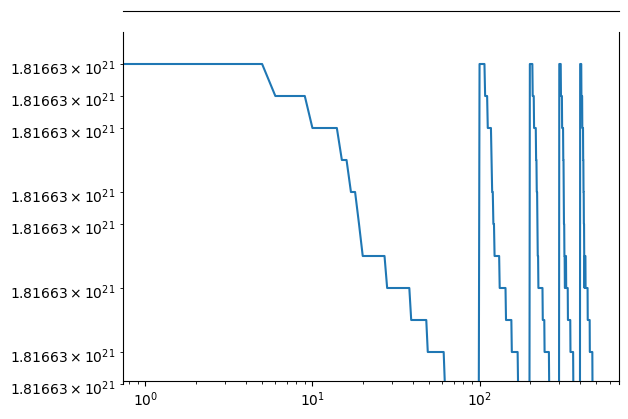

In [21]:
import matplotlib.pyplot as plt

# Convert each tensor in loss_history to a detached NumPy array
loss_history_np = [loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in loss_history]

# If loss_history_np is a 1D list of values, plot directly
plt.loglog(loss_history_np)
plt.show()


SV graph

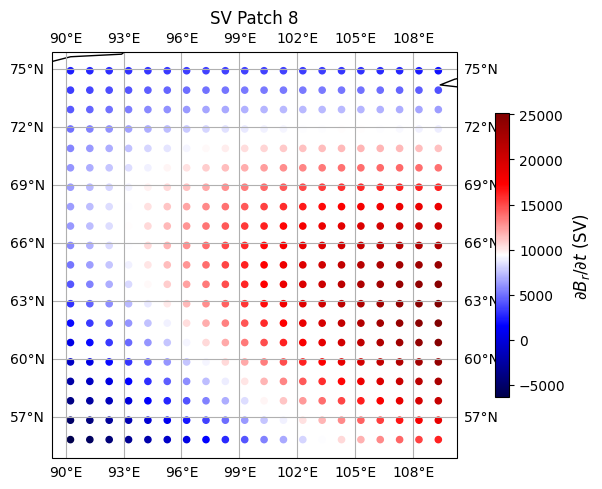

In [22]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

def plot_sv_patch(dBrdt_patch, thetas_bis, phis_bis, patch_id=None):
    # Convert from colatitude (theta) and longitude (phi) to lat/lon degrees
    theta_grid, phi_grid = np.meshgrid(thetas_bis, phis_bis, indexing='ij')
    lat_grid = 90 - np.rad2deg(theta_grid)   # colatitude to latitude
    lon_grid = np.rad2deg(phi_grid)          # radians to degrees longitude

    fig = plt.figure(figsize=(8, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(resolution='110m')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.gridlines(draw_labels=True)

    sc = ax.scatter(lon_grid, lat_grid, c=dBrdt_patch, cmap='seismic', s=20, transform=ccrs.PlateCarree())
    cb = plt.colorbar(sc, orientation='vertical', shrink=0.7, pad=0.05)
    cb.set_label(r'$\partial B_r / \partial t$ (SV)', fontsize=12)

    if patch_id is not None:
        ax.set_title(f'SV Patch {patch_id}')
    else:
        ax.set_title('SV Patch')

    plt.tight_layout()
    plt.show()


plot_sv_patch(dBrdt_patch, thetas_bis, phis_bis, patch_id=len(patch_centers)+1)


above: red for positive (increasing
𝐵
𝑟
 ), blue for negative (decreasing
𝐵
𝑟 ).



In [23]:
_, _,_, u_th, u_ph = compute_loss(model, inputs, thetas_nn, phis_nn, Br_nn, Br_obs, sigma_i, dBrdt_nn, dBrdth_nn, dBrdph_nn)
# Used patch grid sizes, NOT the full global Br shape or else there is shape error
patch_shape = (len(thetas_bis), len(phis_bis))

u_th_map = u_th.reshape(patch_shape).detach().cpu().numpy()
u_ph_map = u_ph.reshape(patch_shape).detach().cpu().numpy()


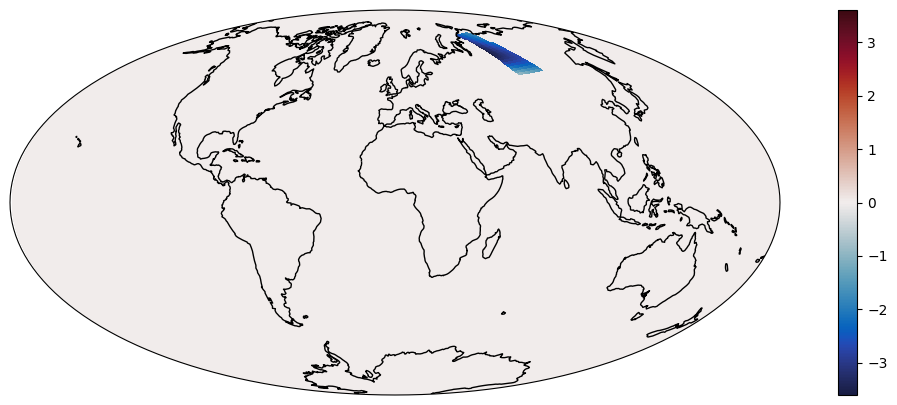

In [24]:
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs

u_th_full = numpy.zeros((thetas.size, phis.size))
u_th_full[i1:i2,j1:j2] = u_th_map

thetas_bis_deg = numpy.rad2deg(thetas)
phis_bis_deg = numpy.rad2deg(phis)

latitudes = pygeo.convertThetasToLatitudes(thetas)
longitudes = pygeo.convertPhisToLongitudes(phis)

lat_grid, lon_grid = numpy.meshgrid(latitudes, longitudes, indexing="ij")

fig = plt.figure(figsize=(15,5))

# Set the projection to Hammer and add the axes
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Aitoff())

u_max = numpy.max(numpy.abs(u_th_full))

# Use `pcolormesh` to project the data onto the map
pcol = ax.pcolormesh(lon_grid, lat_grid, u_th_full, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=-u_max, vmax=u_max)

# Add coastlines for context
ax.coastlines()

plt.colorbar(pcol)